## Saliency Map

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing import image

In [2]:
#mount google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Machine Learning/final_functional_model_4_output.keras'
model = load_model(model_path)


In [4]:
# Wrap it to get gradients working
inputs = tf.keras.Input(shape=(128, 128, 3))
outputs = model(inputs)
saliency_model = tf.keras.Model(inputs, outputs)


In [5]:
# Folder where your sample images are
image_dir = '/content/drive/MyDrive/galaxy_images'

# Get 5 random image paths
all_images = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
sample_images = random.sample(all_images, 5)


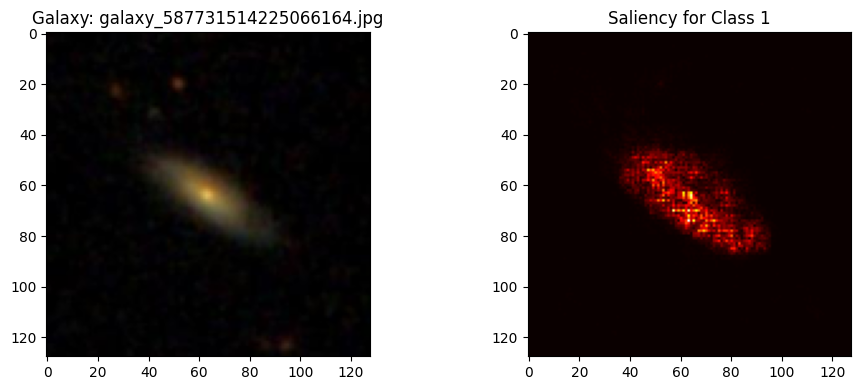

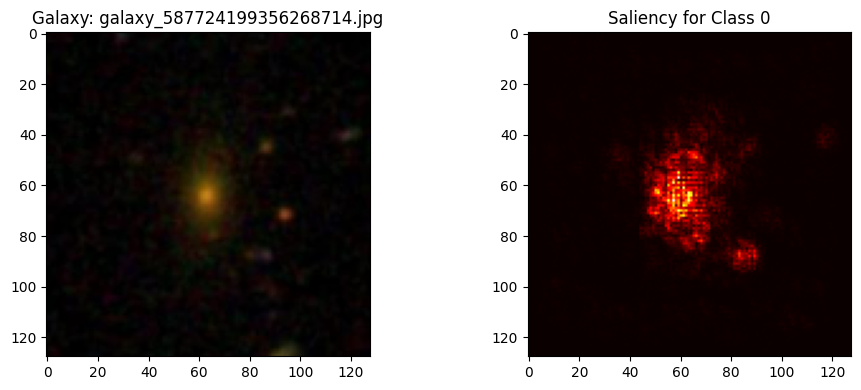

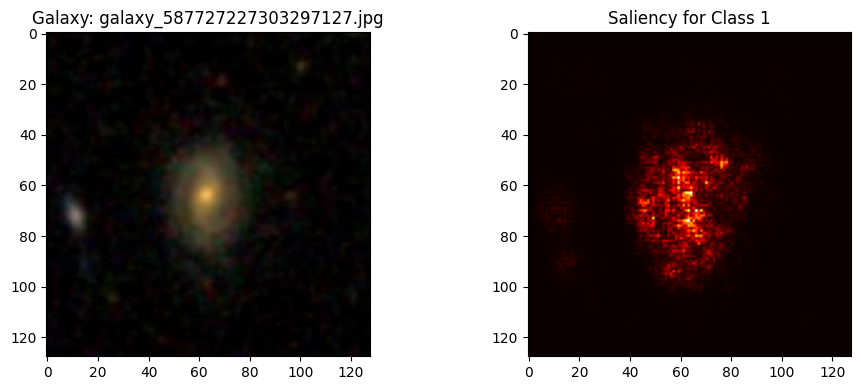

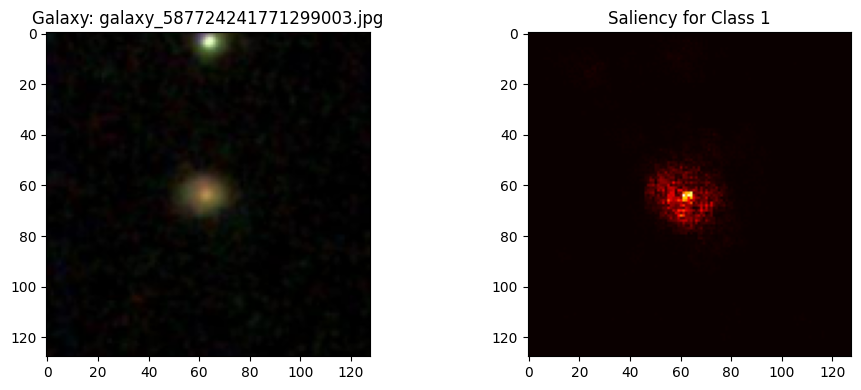

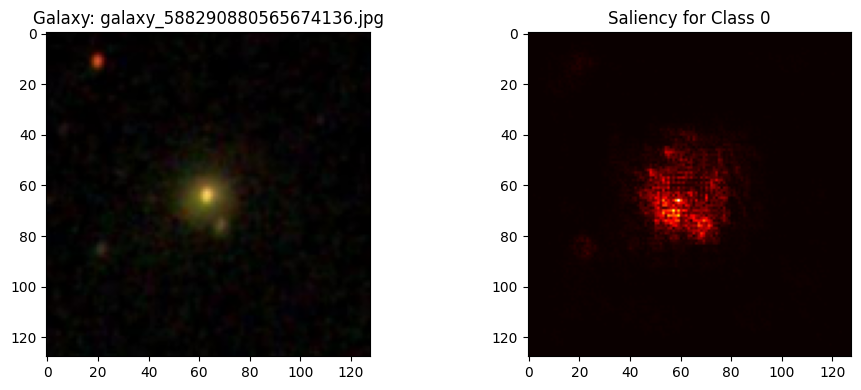

In [ ]:
# Loop over each image and generate saliency map
for img_path in sample_images:
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    img_array = img_array.astype(np.float32)

    # Convert to tensor
    img_tensor = tf.convert_to_tensor(img_array)

    # Gradient tape
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = saliency_model(img_tensor)
        top_class = tf.argmax(preds[0])
        grads = tape.gradient(preds[0][top_class], img_tensor)

    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Plot results
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Galaxy: {os.path.basename(img_path)}')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency.numpy(), cmap='hot')
    plt.title(f'Saliency for Class {int(top_class)}')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

csv_path = '/content/drive/MyDrive/Machine Learning/galaxy_image_labels.csv'
df = pd.read_csv(csv_path)


In [97]:
# Define preprocessing ---
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    return img, np.expand_dims(img_array, axis=0)

# Get predictions ---
true_probs = []
pred_probs = []

for path in sample_images:
    # Load image
    raw_img, input_array = load_and_preprocess_image(path)

    # Predict
    pred = model.predict(input_array)[0]
    pred_probs.append(pred)

    # Get true probabilities from df (fix matching based on how image_path is formatted in df)
    fname = os.path.basename(path)
    true_row = df[df['image_path'].str.contains(fname)]
    true = true_row[[col for col in df.columns if col.startswith('P_')]].values[0]
    true_probs.append(true)

    # Plotting
    labels = [col.replace('P_', '') for col in df.columns if col.startswith('P_')]
    x = np.arange(len(labels))
    width = 0.35

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    # Image
    axs[0].imshow(raw_img)
    axs[0].axis('off')
    axs[0].set_title(f"Galaxy: {fname}")

    # Combined bar chart
    axs[1].bar(x - width/2, true, width, label='True', color='pink', alpha=0.7)
    axs[1].bar(x + width/2, pred, width, label='Predicted', color='blue', alpha=0.7)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels, rotation=45)
    axs[1].set_ylim(0, 1)
    axs[1].set_title("True vs Predicted Class Probabilities")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


KeyError: 'image_path'

# Saliency Maps For Report

In [85]:
import os, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import re

# Define class label columns
class_columns = ['P_EL', 'P_CW', 'P_ACW', 'P_EDGE', 'P_MG', 'P_DK', 'P_EL_DEBIASED', 'P_CS_DEBIASED']

# Your trained model
model = load_model('/content/drive/MyDrive/Machine Learning/final_functional_model_4_output.keras')

# Image folder
image_dir = '/content/drive/MyDrive/galaxy_images'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Load your CSV with true labels
import pandas as pd
labels_df = pd.read_csv('/content/drive/MyDrive/Machine Learning/galaxy_image_labels.csv')  # modify path

# Create a lookup dictionary: OBJID → true label index
label_lookup = {}
for _, row in labels_df.iterrows():
    objid = str(row['OBJID'])
    probs = row[class_columns].values
    label_lookup[objid] = int(np.argmax(probs))

def extract_objid_from_filename(path):
    match = re.search(r'galaxy_(\d+)\.jpg', os.path.basename(path))
    return match.group(1) if match else None



In [67]:

import pandas as pd
from tqdm import tqdm

results = []
save_path = '/content/drive/MyDrive/intermediate_results.csv'  # Update path if needed

for path in tqdm(image_paths):
    objid = extract_objid_from_filename(path)
    if objid not in label_lookup:
        continue

    true_class = label_lookup[objid]
    img = image.load_img(path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    preds = model.predict(img_array, verbose=0)  # Suppress output fully
    pred_class = np.argmax(preds[0])
    prob = preds[0][pred_class]

    results.append({
        'path': path,
        'true': true_class,
        'pred': pred_class,
        'prob': prob,
        'correct': true_class == pred_class
    })

    # Save progress after each iteration
    pd.DataFrame(results).to_csv(save_path, index=False)

df = pd.DataFrame(results)
df.to_csv('/content/drive/MyDrive/Machine Learning/galaxy_prediction_results_final.csv', index=False)


"\nimport pandas as pd\nfrom tqdm import tqdm\n\nresults = []\nsave_path = '/content/drive/MyDrive/intermediate_results.csv'  # Update path if needed\n\nfor path in tqdm(image_paths):\n    objid = extract_objid_from_filename(path)\n    if objid not in label_lookup:\n        continue\n\n    true_class = label_lookup[objid]\n    img = image.load_img(path, target_size=(128, 128))\n    img_array = image.img_to_array(img)\n    img_array = np.expand_dims(img_array, axis=0) / 255.0\n\n    preds = model.predict(img_array, verbose=0)  # Suppress output fully\n    pred_class = np.argmax(preds[0])\n    prob = preds[0][pred_class]\n\n    results.append({\n        'path': path,\n        'true': true_class,\n        'pred': pred_class,\n        'prob': prob,\n        'correct': true_class == pred_class\n    })\n\n    # Save progress after each iteration\n    pd.DataFrame(results).to_csv(save_path, index=False)\n\ndf = pd.DataFrame(results)\ndf.to_csv('/content/drive/MyDrive/Machine Learning/galaxy_p

In [86]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/galaxy_prediction_results_final.csv')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     16836
           1       0.00      0.00      0.00       153
           2       0.00      0.00      0.00       206
           3       0.00      0.00      0.00       123
           4       0.00      0.00      0.00       405
           5       0.80      0.03      0.05       152
           6       0.00      0.00      0.00         0
           7       0.81      0.85      0.83     12125

    accuracy                           0.84     30000
   macro avg       0.31      0.22      0.22     30000
weighted avg       0.82      0.84      0.83     30000



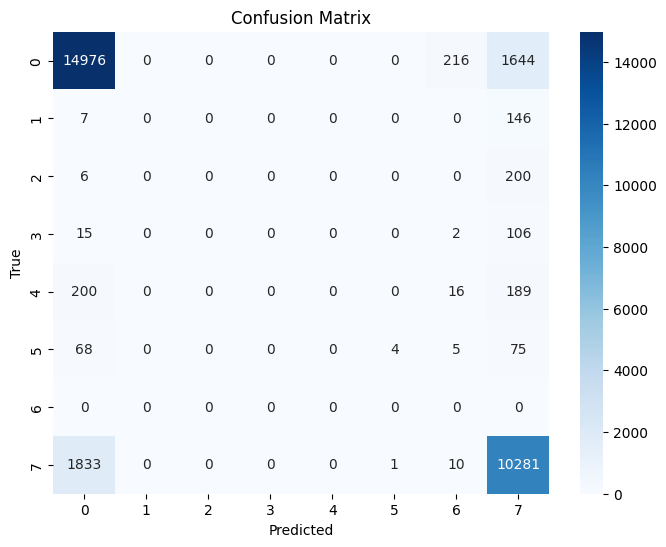

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels = df['true']
predicted_labels = df['pred']

# Classification Report
print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [70]:
#strategic sampling



def sample(df, condition, n=1):
    subset = df.query(condition)
    return subset.sample(n=min(n, len(subset))) if not subset.empty else pd.DataFrame()

selected = pd.concat([
    sample(df, "correct and prob > 0.8"),
    sample(df, "correct and prob <= 0.6"),
    sample(df, "~correct and prob > 0.7"),
    sample(df, "~correct and prob <= 0.5"),
    sample(df, "true in [5,6]")
])


In [87]:
class_names = [ 'EDGE', 'MG','EL_DEBIASED', 'CS_DEBIASED']


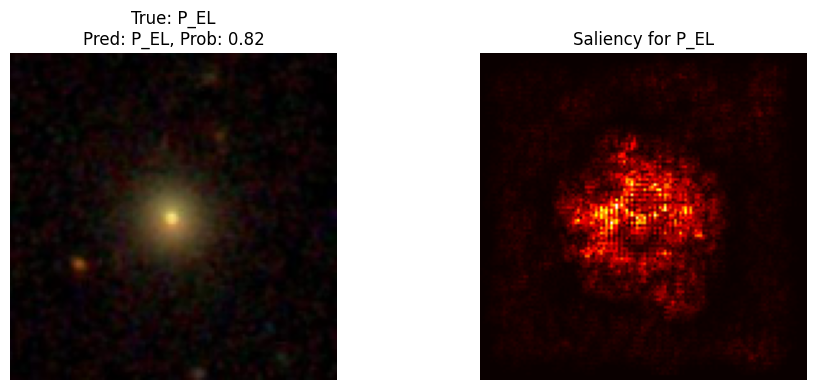

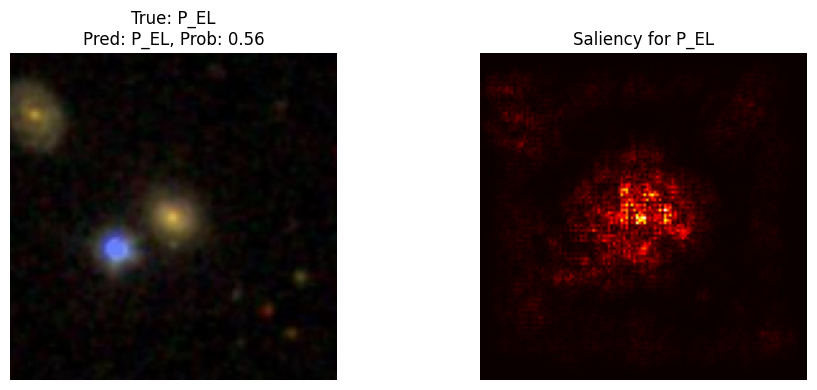

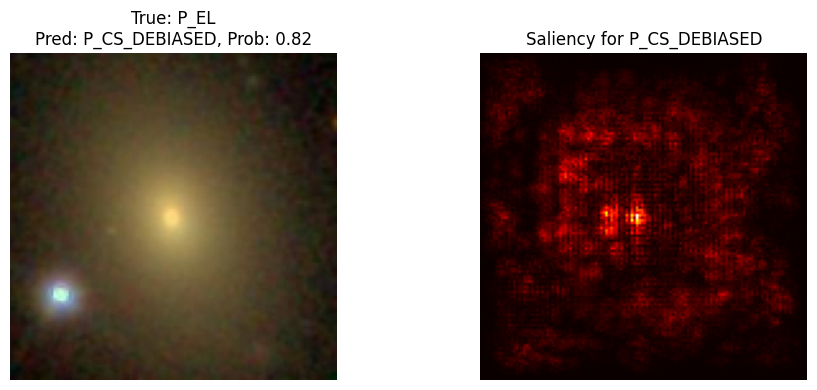

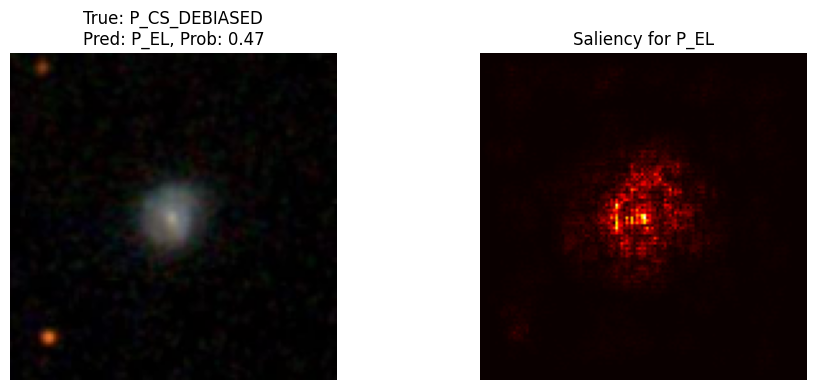

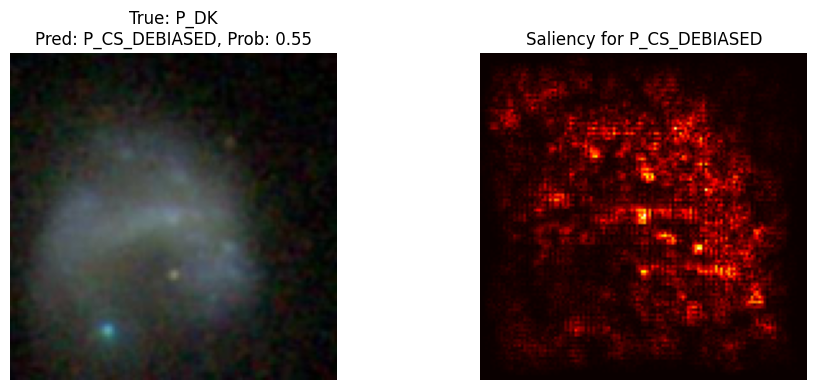

In [74]:
#generate saliency maps

for i, row in selected.iterrows():
    path, true_cls, pred_cls, prob = row['path'], row['true'], row['pred'], row['prob']
    img = image.load_img(path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_class = tf.argmax(preds[0])
        grads = tape.gradient(preds[0][top_class], img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}, Prob: {prob:.2f}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency.numpy(), cmap='hot')
    plt.title(f'Saliency for {class_names[pred_cls]}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [82]:
# print batch of correctly predicted maps

def display_correct_predictions(df, model, class_names, n=5):
    # Filter for correct predictions
    correct_df = df[df['correct']].sample(n=min(n, len(df)))

    for _, row in correct_df.iterrows():
        path, true_cls, pred_cls, prob = row['path'], row['true'], row['pred'], row['prob']

        # Load and preprocess image
        img = image.load_img(path, target_size=(128, 128))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

        # Generate saliency map
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            preds = model(img_tensor)
            top_class = tf.argmax(preds[0])
            grads = tape.gradient(preds[0][top_class], img_tensor)
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

        # Plot the original image and saliency map
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}, Prob: {prob:.2f}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency.numpy(), cmap='hot')
        plt.title(f"Saliency for {class_names[pred_cls]}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


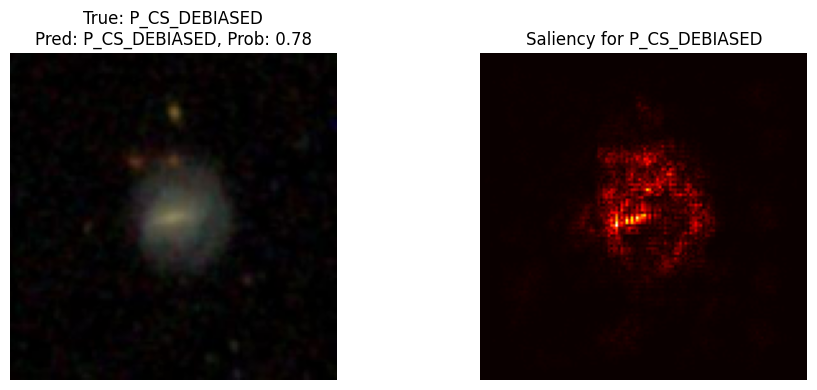

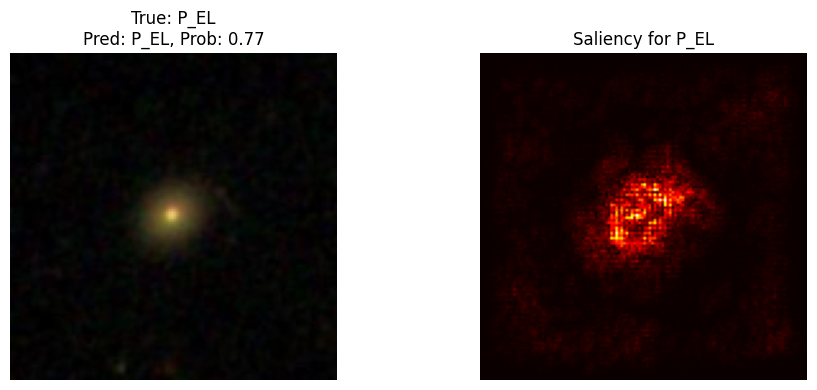

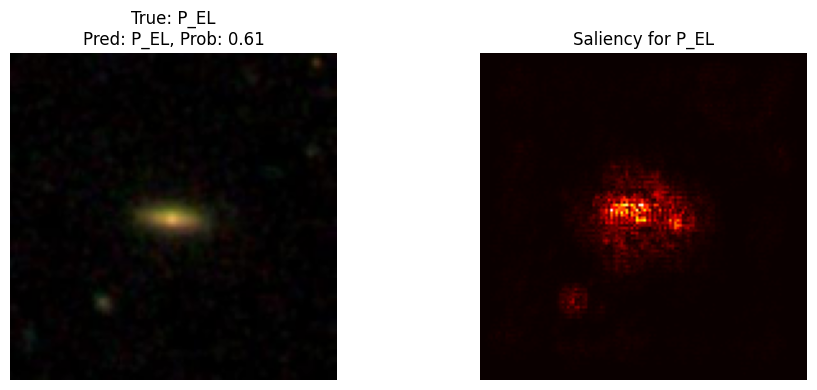

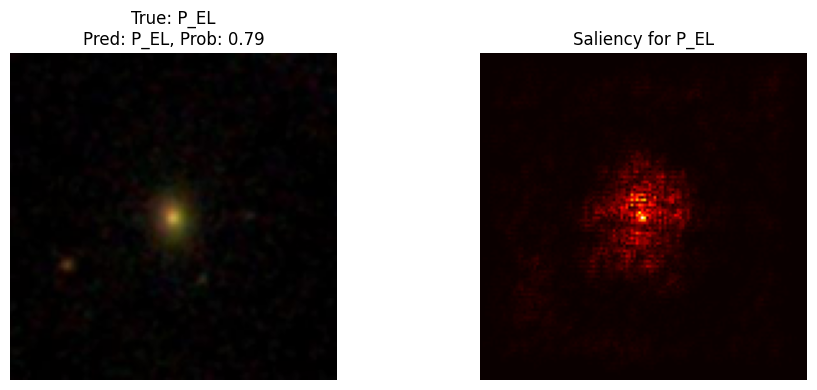

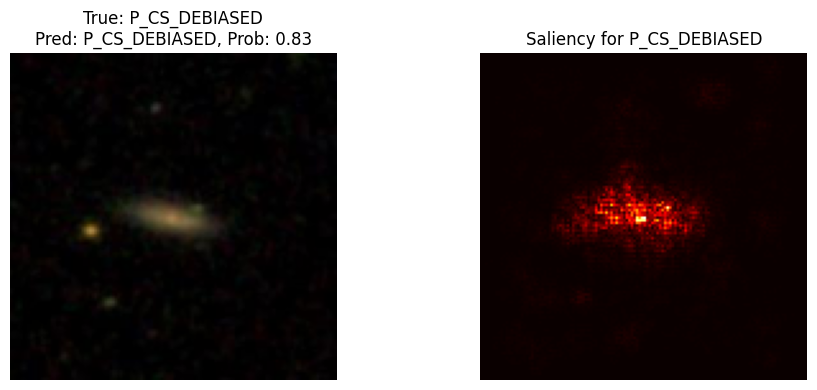

In [83]:
display_correct_predictions(df, model, class_names, n=5)


In [ ]:
# print a chart of class imbalance
import matplotlib.pyplot as plt

# Compute class counts
class_counts = df['true'].value_counts().sort_index()
labels = [class_names[i] for i in class_counts.index]

# Plot the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, class_counts, color='skyblue')

# Annotate counts on top of each bar
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


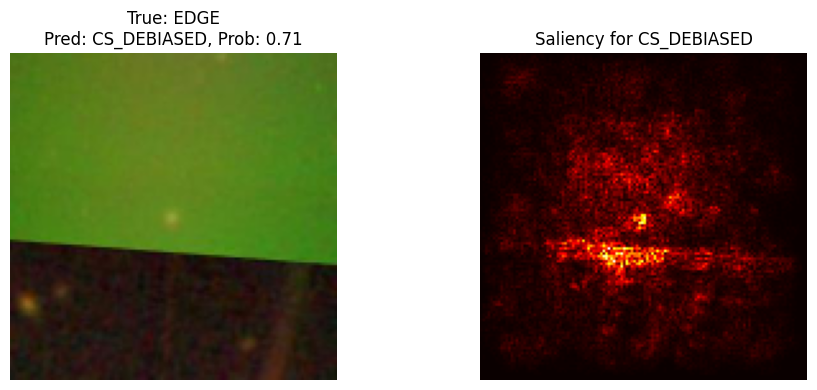

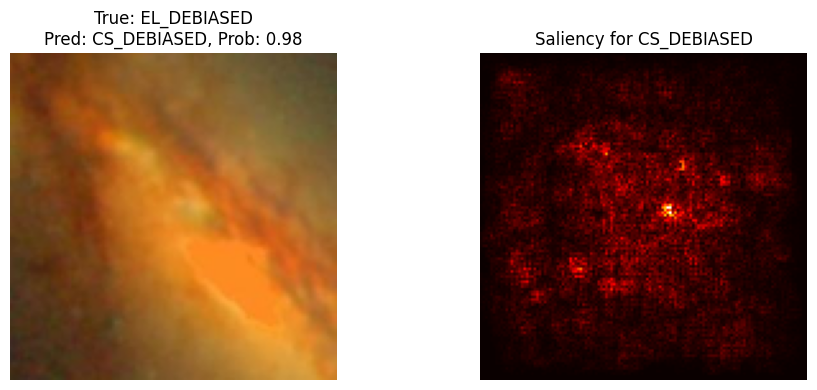

In [90]:
# Show examples where the true label OR the predicted label is 'P_EDGE'
edge_on_df = df[
    (df['true'] == class_columns.index('P_EDGE')) |
    (df['pred'] == class_columns.index('P_EDGE'))
]

# Sample N examples
edge_on_sample = edge_on_df.sample(n=2)  # Show 5 random examples, adjust as needed

for _, row in edge_on_sample.iterrows():
    path, true_cls, pred_cls, prob = row['path'], row['true'], row['pred'], row['prob']
    img = image.load_img(path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Generate saliency map
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_class = tf.argmax(preds[0])
        grads = tape.gradient(preds[0][top_class], img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    # Plot image and saliency map
    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]}, Prob: {prob:.2f}")
    plt.axis('off')

    # Saliency Map
    plt.subplot(1, 2, 2)
    plt.imshow(saliency.numpy(), cmap='hot')
    plt.title(f"Saliency for {class_names[pred_cls]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Report images/tables

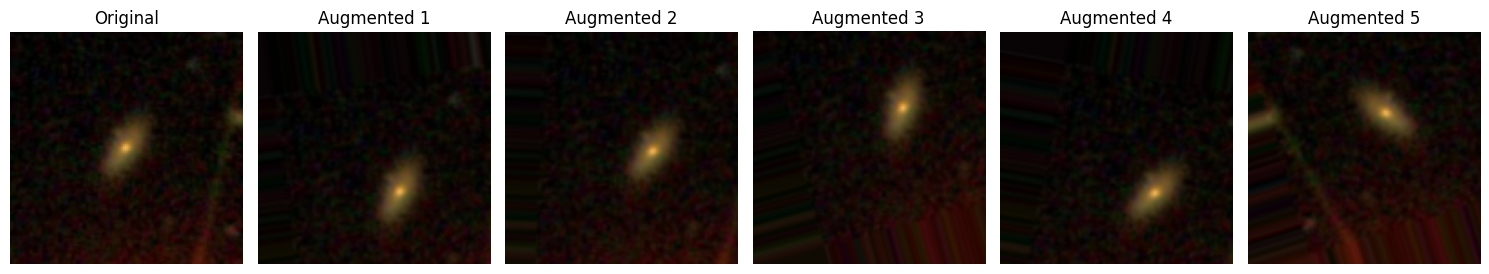

In [101]:
#visualization for data augmentation techniques

import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img



# Define the image directory and get one random image to visualize augmentation
image_dir = '/content/drive/MyDrive/galaxy_images'
all_images = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
sample_image_path = random.choice(all_images)

# Load and preprocess the image
img = load_img(sample_image_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Set up ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Generate augmented images
aug_iter = datagen.flow(img_array, batch_size=1)

# Plot original + 5 augmented versions
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original')
axes[0].axis('off')

for i in range(1, 6):
    augmented_img = next(aug_iter)[0]
    axes[i].imshow(augmented_img)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



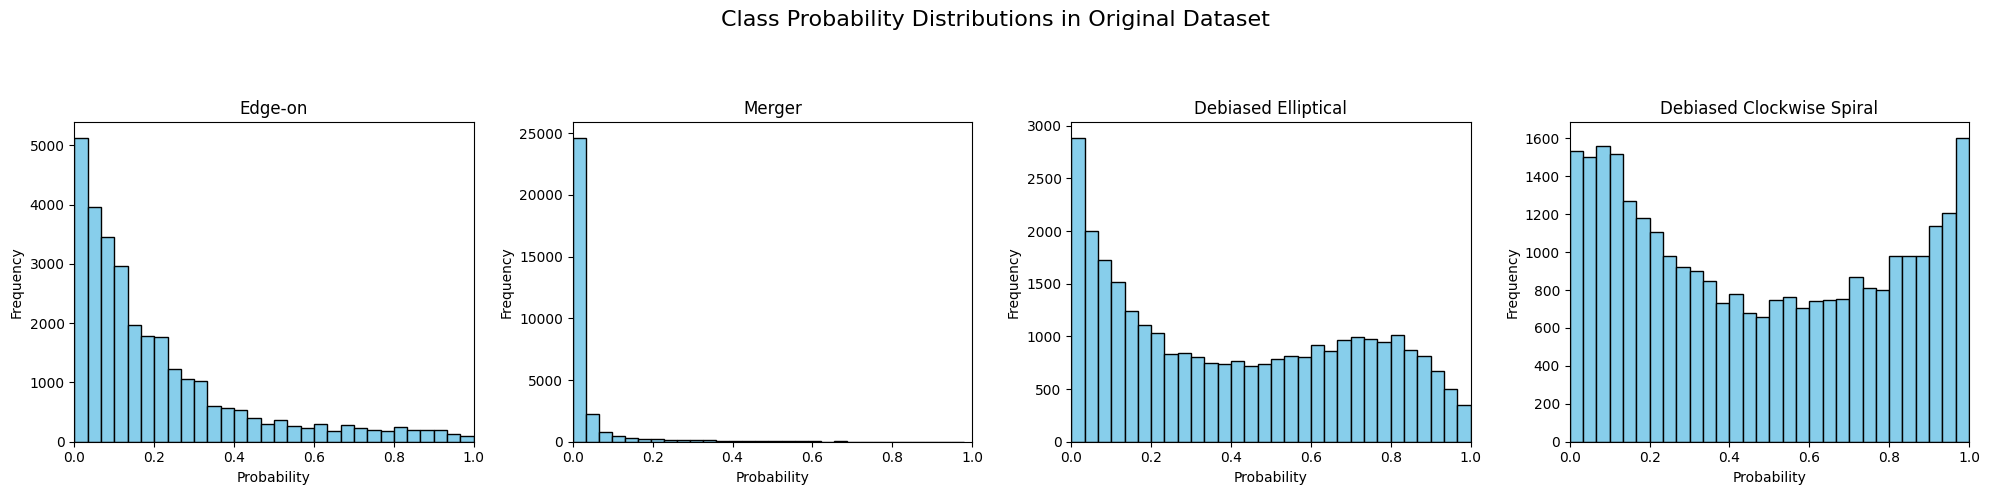

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/galaxy_image_labels.csv')

# Class probability columns with readable names
prob_cols = {
    'P_EDGE': 'Edge-on',
    'P_MG': 'Merger',
    'P_EL_DEBIASED': 'Debiased Elliptical',
    'P_CS_DEBIASED': 'Debiased Clockwise Spiral'
}

# Plot histograms for each class probability distribution
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Adjusted layout since only 4 plots

fig.suptitle('Class Probability Distributions in Original Dataset', fontsize=16)

for idx, (col, readable_name) in enumerate(prob_cols.items()):
    ax = axes[idx]
    ax.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(readable_name)
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    ax.set_xlim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


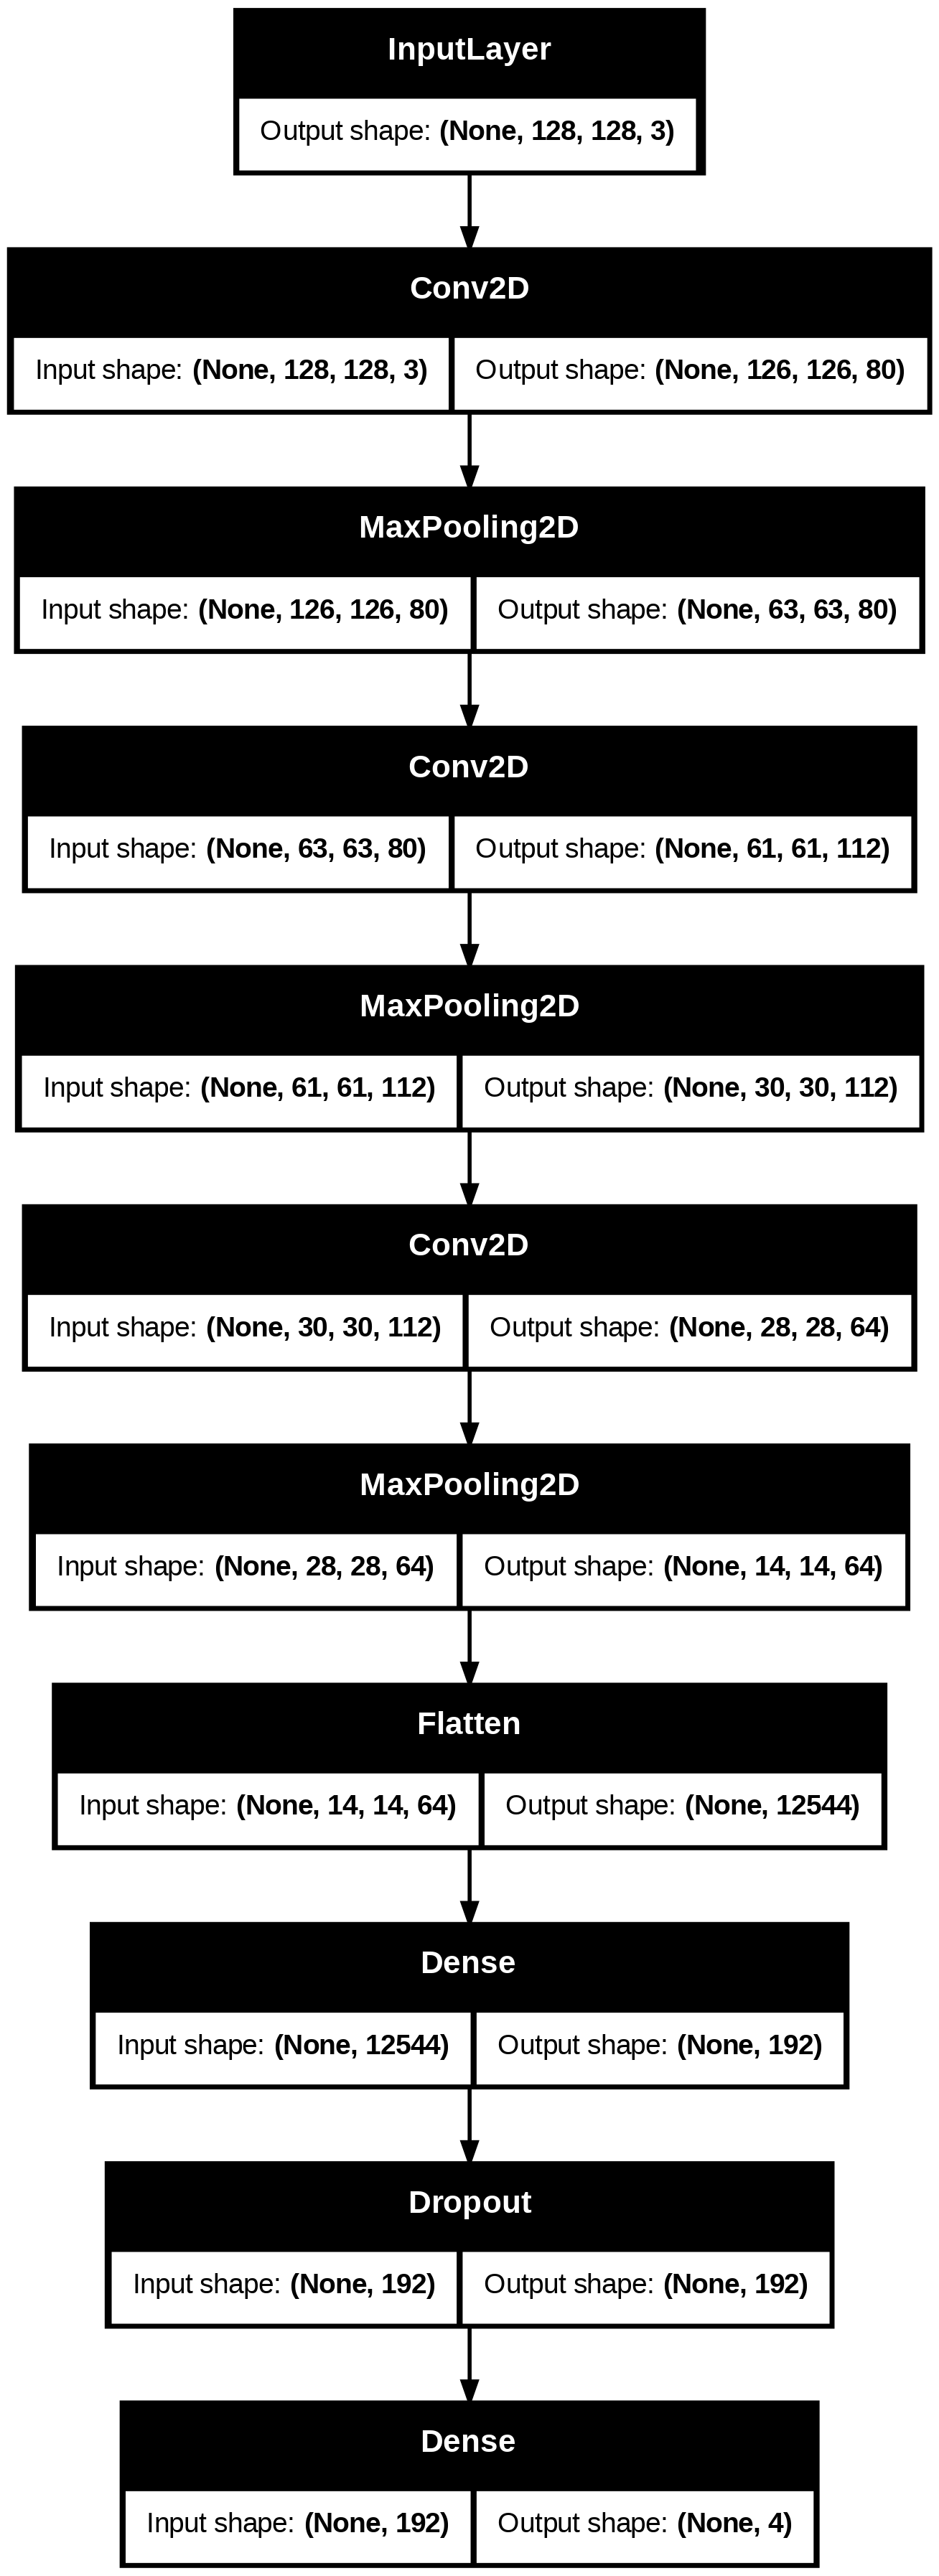

In [19]:
#model architecture figure

from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)


In [21]:
import pandas as pd

# Final selected hyperparameters based on your model tuning
hyperparams = {
    'Hyperparameter': [
        'Number of Conv Layers',
        'Filter Sizes',
        'Dense Layer Units',
        'Dropout Rate',
        'Learning Rate',
        'Activation Function',
        'Optimizer',
        'Loss Function'
    ],
    'Final Value': [
        '3',
        '[80, 112, 64]',
        '192',
        '0.1',
        '0.0008',
        'ReLU (Hidden), Sigmoid (Output)',
        'Adam',
        'Mean Squared Error (MSE)'
    ]
}

# Create and display DataFrame
hyperparams_df = pd.DataFrame(hyperparams)

import ace_tools as tools; tools.display_dataframe_to_user(name="hyperparams_df", dataframe=hyperparams_df)

# Optionally save to CSV for report inclusion
hyperparams_df.to_csv('/mnt/data/final_hyperparameters.csv', index=False)



ModuleNotFoundError: No module named 'ace_tools'

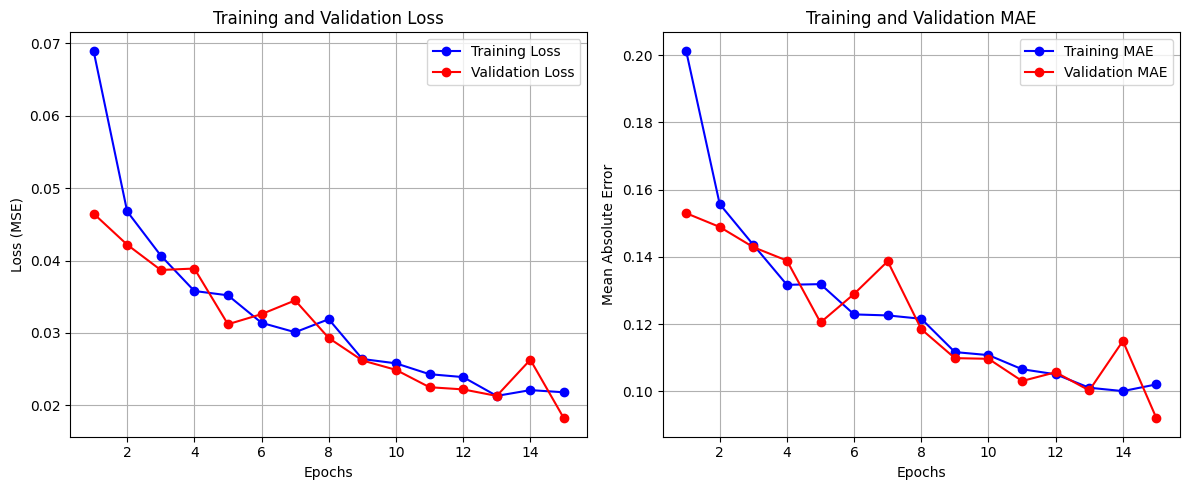

In [95]:
import matplotlib.pyplot as plt

# Manually entered from logs (15 epochs)
loss = [0.0690, 0.0468, 0.0407, 0.0358, 0.0352, 0.0314, 0.0301, 0.0319, 0.0264, 0.0258, 0.0243, 0.0239, 0.0213, 0.0221, 0.0218]
val_loss = [0.0465, 0.0422, 0.0387, 0.0389, 0.0312, 0.0326, 0.0345, 0.0293, 0.0262, 0.0249, 0.0225, 0.0222, 0.0213, 0.0263, 0.0182]

mae = [0.2013, 0.1557, 0.1436, 0.1317, 0.1319, 0.1229, 0.1226, 0.1216, 0.1117, 0.1108, 0.1066, 0.1051, 0.1011, 0.1001, 0.1021]
val_mae = [0.1530, 0.1489, 0.1429, 0.1389, 0.1205, 0.1290, 0.1387, 0.1185, 0.1099, 0.1097, 0.1031, 0.1057, 0.1003, 0.1150, 0.0920]

epochs = range(1, 16)

# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


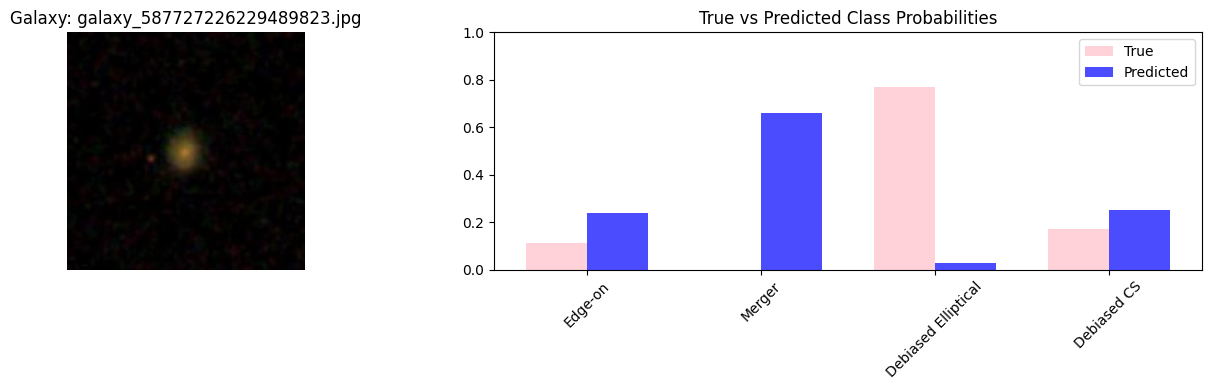

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


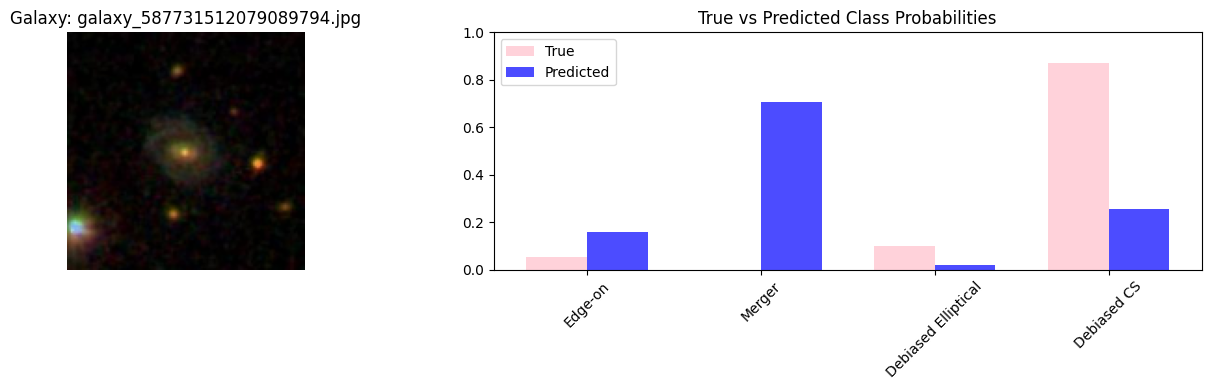

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


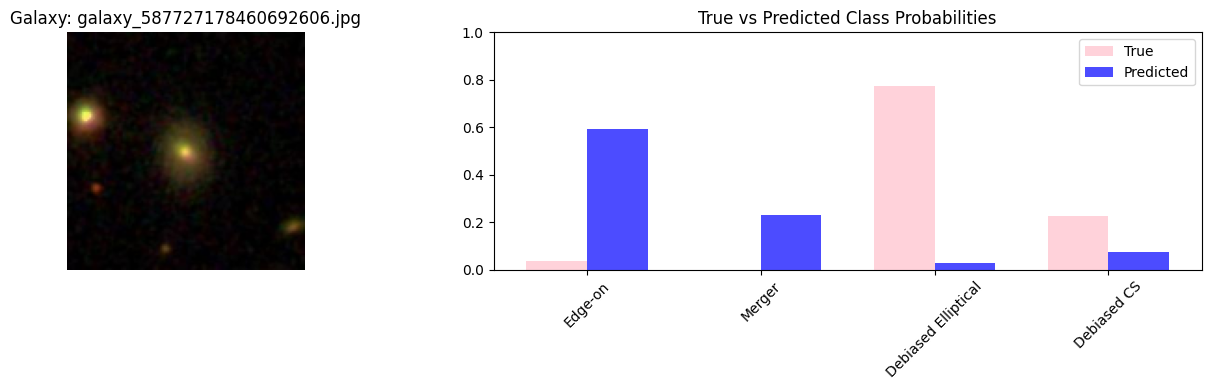

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


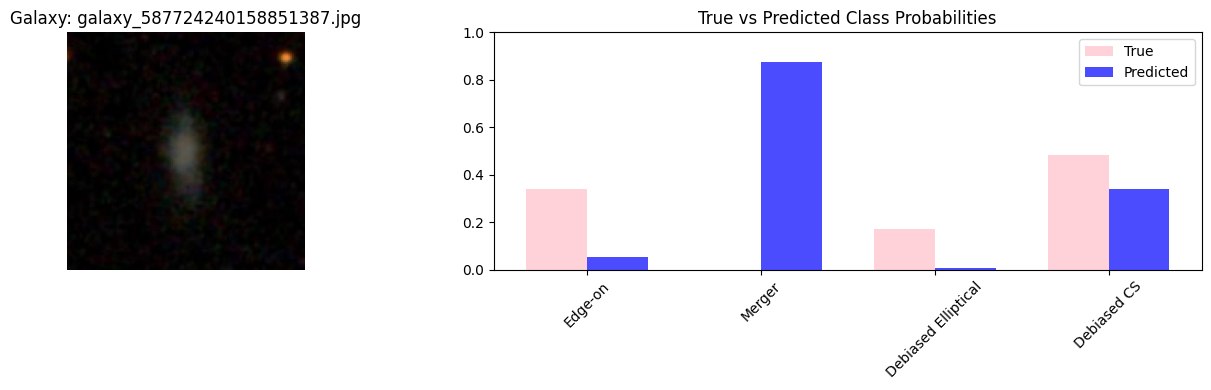

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


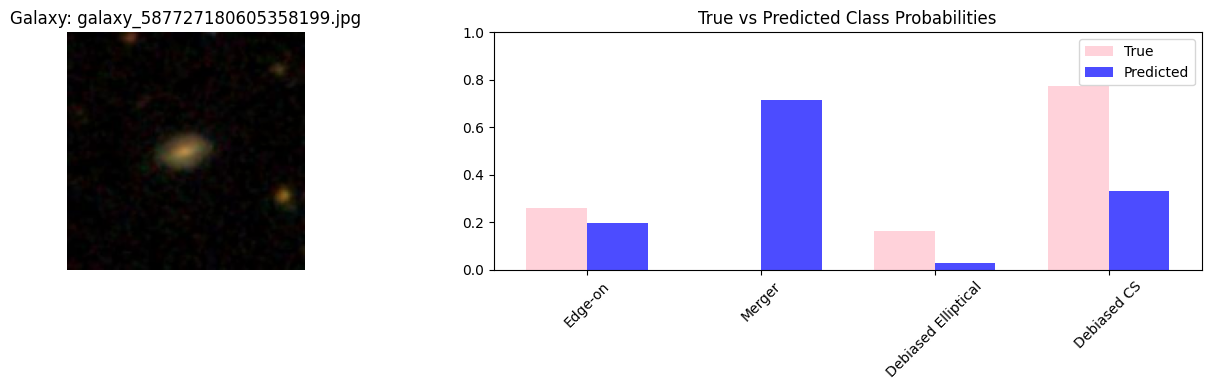

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

df = pd.read_csv('/content/drive/MyDrive/Machine Learning/galaxy_image_labels.csv')
# --- STEP 1: Define preprocessing ---
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    return img, np.expand_dims(img_array, axis=0)

# --- STEP 2: Define the four class columns and readable names ---
class_columns = ['P_EDGE', 'P_MG', 'P_EL_DEBIASED', 'P_CS_DEBIASED']
readable_labels = ['Edge-on', 'Merger', 'Debiased Elliptical', 'Debiased CS']

true_probs = []
pred_probs = []

for path in sample_images:
    # Load image
    raw_img, input_array = load_and_preprocess_image(path)

    # Predict probabilities for the 4 classes
    pred = model.predict(input_array)[0]
    pred_probs.append(pred)

    # Get true probabilities from df (ensure matching by filename)
    fname = os.path.basename(path)
    true_row = df[df['image_path'].str.contains(fname)]
    true = true_row[class_columns].values[0]
    true_probs.append(true)

    # Plotting
    x = np.arange(len(readable_labels))
    width = 0.35

    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    # Image
    axs[0].imshow(raw_img)
    axs[0].axis('off')
    axs[0].set_title(f"Galaxy: {fname}")

    # Combined Bar Chart
    axs[1].bar(x - width/2, true, width, label='True', color='pink', alpha=0.7)
    axs[1].bar(x + width/2, pred, width, label='Predicted', color='blue', alpha=0.7)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(readable_labels, rotation=45)
    axs[1].set_ylim(0, 1)
    axs[1].set_title("True vs Predicted Class Probabilities")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


In [99]:
print(df.columns)


Index(['path', 'true', 'pred', 'prob', 'correct'], dtype='object')
